In [47]:
# Polynomial Regression
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [48]:
# Generating the Dataset
max_degree = 20 # Maximum degree of the polynomial
n_train, n_test = 100, 100 # Training and test dataset sizes
true_w = np.zeros(max_degree) # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
# Shape of 'labels': ('n_train' + 'n_test',)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # scale refers to the standard deviation

In [49]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    tf.constant(x, dtype=tf.float32) for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.41496044],
        [1.1759263 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[1.00000000e+00, 4.14960444e-01, 8.60960856e-02, 1.19088236e-02,
         1.23542268e-03, 1.02530314e-04, 7.09100414e-06, 4.20355178e-07,
         2.18038476e-08, 1.00530384e-09, 4.17161305e-11, 1.57368584e-12,
         5.44181162e-14, 1.73702815e-15, 5.14855709e-17, 1.42429831e-18,
         3.69392172e-20, 9.01665541e-22, 2.07864186e-23, 4.53975892e-25],
        [1.00000000e+00, 1.17592633e+00, 6.91401362e-01, 2.71012366e-01,
         7.96726421e-02, 1.87378321e-02, 3.67238489e-03, 6.16922043e-04,
         9.06818532e-05, 1.18483540e-05, 1.39327915e-06, 1.48944864e-07,
         1.45956829e-08, 1.32026523e-09, 1.10895335e-10, 8.69364910e-12,
         6.38943217e-13, 4.41970679e-14, 2.88736083e-15, 1.78701241e-16]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.326046 , 5.6732826], dtype=

In [50]:
# Training and Testing the Model
def evaluate_loss(net, data_iter, loss): #@save
    """"Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2) # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [51]:
def train(train_features, test_features, train_labels, test_labels,
num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1] # number of covariates를 의미하는 것 같다.
    # Switch off the bias since we already catered for it in the polynomial.
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    # Look at ch3.3 part again.
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
    is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
    xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (
                evaluate_loss(net, train_iter, loss), 
                evaluate_loss(net, test_iter, loss)
            ))
    # 일단 다음 부분으로 가서 확인을 해봅시다.
    # Format을 깔끔해게 하기 위해서 'net.get_weights()'에 다음과 같은 조작을 가하였습니다.        
    print('weight:', net.get_weights()[0].T) 

weight: [[ 4.99824    1.1982565 -3.4035249  5.585438 ]]


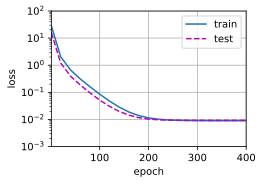

In [52]:
# Third-Order Polynomial Function Fitting (Normal)
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
labels[:n_train], labels[n_train:])

weight: [[3.4833012 4.0549817]]


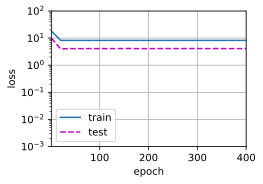

In [53]:
# Linear Function Fitting (Underfitting)
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])

weight: [[ 4.9924850e+00  1.2859439e+00 -3.3532100e+00  5.0739603e+00
  -2.0143205e-01  1.5320233e+00 -9.7249364e-03 -3.7897448e-03
   9.6609160e-02  4.2012423e-01 -3.2111314e-01  2.7580541e-01
   4.0798643e-01 -2.2585730e-01  2.5385711e-01 -2.3493029e-01
  -1.7371728e-01  1.7293441e-01  2.9888231e-01 -3.9358366e-01]]


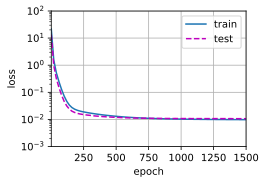

In [54]:
# Higher-order Polynomial Function Fitting (Overfitting)
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)